In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import joblib

# Load and prepare data
data = pd.read_feather("/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data.feather")
    
def apply_constraints(quantities, inventory_data):
    # Convert quantities to a NumPy array if not already
    quantities_np = np.array(quantities, dtype=float)
    
    # Calculate minimum quantities based on reorder point and safety stock
    min_quantities = np.maximum(0, inventory_data['reorder_point'] + inventory_data['safety_stock'])

    # Set quantities for obsolete items to zero
    obsolete_mask = inventory_data['inventory_category'] == 'obsolete'
    non_obsolete_mask = non_obsolete_mask = ~obsolete_mask
    quantities_np[non_obsolete_mask] = np.maximum(quantities_np[non_obsolete_mask], min_quantities[non_obsolete_mask])
    quantities_np[obsolete_mask] = 0


    # Ensure that all quantities are at least the sum of the reorder point and safety stock
    quantities_np = np.maximum(quantities_np, min_quantities)

    return quantities_np


def total_obsolescence_risk(quantities, data):
    # Calculate total risk as the sum of product of risk score and quantities
    return np.sum(quantities * data['obsolescence_risk'])

def objective_function_quantities(quantities, data):
    # Calculate the objective function based on the quantities
    # This function should directly evaluate the cost, revenue, or other metrics based on the quantities
    total_cost = np.sum(quantities * data['cost_per_unit'])
    revenue = np.sum(quantities * data['price'])
    risk = np.sum(quantities * data['obsolescence_risk'])
    return -revenue + total_cost + risk 

# Define constraints for the quantities
constraints = [{'type': 'ineq', 'fun': lambda q: apply_constraints(q, data) - q}]

# Initial guess for the quantities
initial_quantities = data['quantity']  

# Perform the optimization
result = minimize(
    fun=objective_function_quantities,
    x0=initial_quantities,
    args=(data,),
    constraints=constraints,
    method='SLSQP'
)

result

joblib.dump('Dashboard/Models/optimal_stock/optimal_stock_model.joblib')

KeyError: 'reorder_point'

In [ ]:
joblib.load('Dashboard/Models/optimal_stock/optimal_stock_model.joblib')

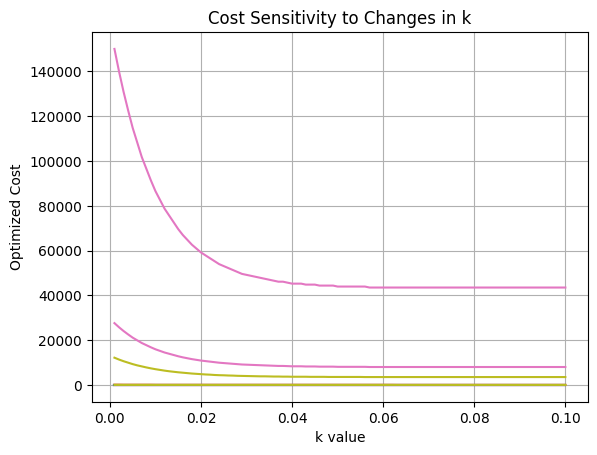

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sampled_data = data.sample(n=10, random_state=1)

def calculate_optimized_quantities(k, data):
    base_level = 0.01
    # Adjust k using a sigmoid function to smooth transitions
    scaled_k = sigmoid((k - 0.01) * 100)  # Scale and shift to adjust sensitivity
    risk_factor = data['obsolescence_risk'] + base_level
    optimized_quantities = 1 / (scaled_k * risk_factor)
    return apply_constraints(optimized_quantities, data)

k_values = np.linspace(0.001, 0.1, 100)  # More granular steps around the threshold
results = {}
for k in k_values:
    optimized_quantities = calculate_optimized_quantities(k, sampled_data)
    data['optimized_quantity'] = optimized_quantities.astype(int)
    optimized_cost = (data['optimized_quantity']* data['cost_per_unit'])
    results[k] = optimized_cost

# Plotting to visualize the effect
import matplotlib.pyplot as plt
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel('k value')
plt.ylabel('Optimized Cost')
plt.title('Cost Sensitivity to Changes in k')
plt.grid(True)
plt.show()

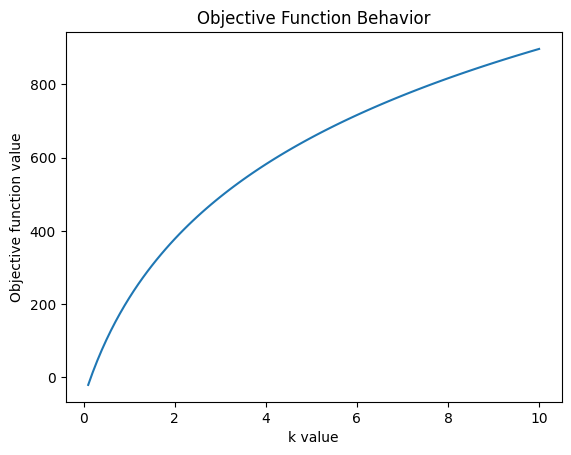

In [12]:
import matplotlib.pyplot as plt

k_values = np.linspace(0.1, 10, 100)
objectives = [objective_function([k], data) for k in k_values]

plt.plot(k_values, objectives)
plt.xlabel('k value')
plt.ylabel('Objective function value')
plt.title('Objective Function Behavior')
plt.show()

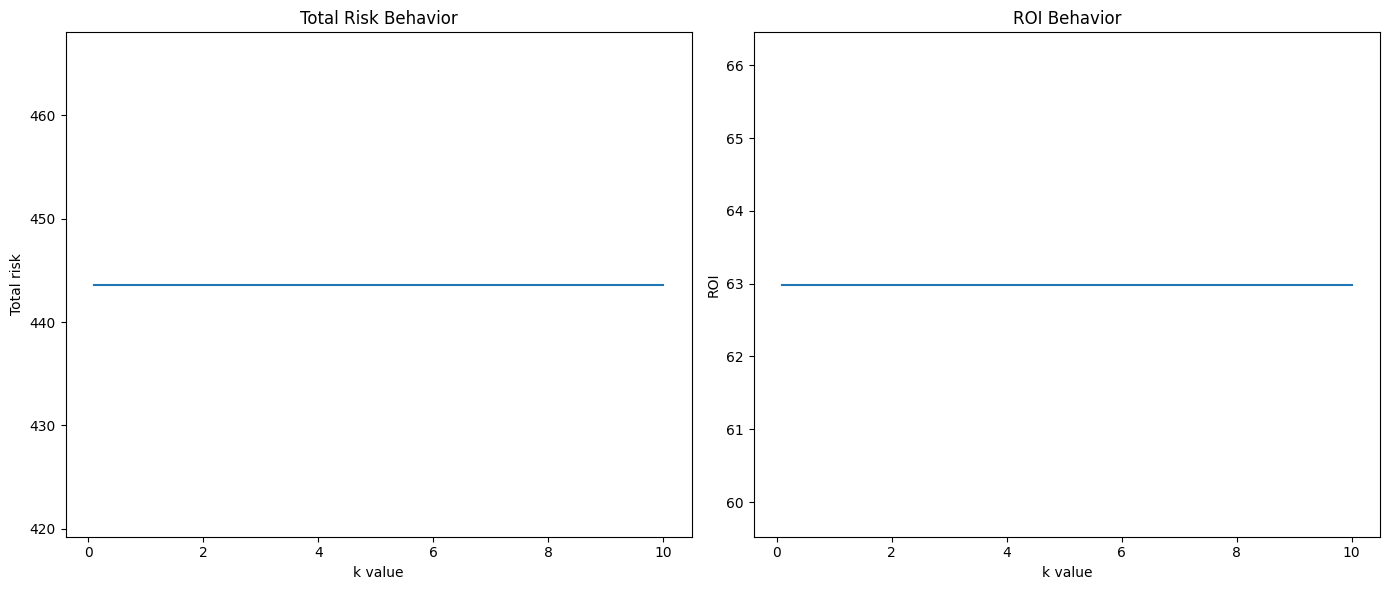

In [13]:
risks = [total_obsolescence_risk(apply_constraints(optimized_k / (data['obsolescence_risk'] + 0.01), data), data) for k in k_values]
rois = [(np.sum(apply_constraints(optimized_k / (data['obsolescence_risk'] + 0.01), data) * data['price']) - np.sum(apply_constraints(optimized_k / (data['obsolescence_risk'] + 0.01), data) * data['cost_per_unit'])) / (np.sum(apply_constraints(optimized_k / (data['obsolescence_risk'] + 0.01), data) * data['cost_per_unit']) + 0.01) * 100 for k in k_values]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, risks)
plt.xlabel('k value')
plt.ylabel('Total risk')
plt.title('Total Risk Behavior')

plt.subplot(1, 2, 2)
plt.plot(k_values, rois)
plt.xlabel('k value')
plt.ylabel('ROI')
plt.title('ROI Behavior')

plt.tight_layout()
plt.show()

In [8]:
columns = ['part_number', 'description', 'supplier_name', 'quantity', 
           'optimized_quantity', 'price',
           'margin', 'months_no_sale','rolling_12_month_sales', 
           '90_day_turnover', '90_days_supply','demand',
           'obsolescence_risk', 'inventory_category', 'reorder_point',
           'safety_stock']

mask = data['optimized_quantity'] > 0

opt_df = data[columns][mask].sort_values(by='optimized_quantity', ascending=False)
print(f"New quantity sum: {opt_df['optimized_quantity'].sum()} units")
print(f"Old quantity sum: {data[mask]['quantity'].sum()} units")

data.loc[(data['quantity']) < data['optimized_quantity']][mask][columns]



New quantity sum: 124360 units
Old quantity sum: 21699 units


/var/folders/59/vc05kjdn7s14r9w654dq4xlh0000gn/T/ipykernel_14038/615076894.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.loc[(data['quantity']) < data['optimized_quantity']][mask][columns]


,part_number,description,supplier_name,quantity,optimized_quantity,price,margin,months_no_sale,rolling_12_month_sales,90_day_turnover,90_days_supply,demand,obsolescence_risk,inventory_category,reorder_point,safety_stock
2,004hf113,hi-flo o-filt hon 15412-hm5-a1,thibault canada,1,26,4.99,1.75,3,1,1.0,90.0,0.122280,9.470000e-08,non-essential,0,0
4,0069922bc,new style universal cruise ctr,thibault canada,1,22,18.99,9.50,5,2,0.0,0.0,0.655554,1.751321e-03,non-essential,0,0
5,0069925b,"universal cruise control 1""",thibault canada,1,4,18.99,9.50,0,1,0.0,0.0,0.258397,4.614408e-02,non-essential,0,0
7,009md4179ac,rotor rr. kawasaki,thibault canada,0,26,376.99,113.10,2,1,0.0,0.0,0.284942,1.002000e-07,non-essential,0,0
8,01-00330,"irc,gp-21f",gamma sales inc.,0,26,119.99,43.32,2,1,0.0,0.0,0.175368,1.043000e-07,non-essential,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15576,triumph-2451,"bplug,scram,1200",triumph,0,24,259.99,22.33,4,1,0.0,0.0,0.494528,1.189877e-03,non-essential,0,0
15578,v33001,large fuel filter,moto,1,26,6.95,3.06,0,0,0.0,0.0,0.113222,2.870000e-07,non-essential,0,0
15583,yt12b-bs,yt12b-bs w/acid pack,parts canada/power twins,12,26,179.99,72.92,3,29,0.1,1080.0,0.993081,9.470000e-08,essential,4,1
15584,ytx14-bs,ytx14-bs maintenance free batt,parts canada/power twins,1,25,154.99,40.93,5,2,0.0,0.0,0.763995,5.368734e-04,non-essential,0,0


In [7]:
ndf.loc[ndf['optimized_quantity'] == 26][columns]

,part_number,description,supplier_name,quantity,optimized_quantity,price,margin,months_no_sale,rolling_12_month_sales,90_day_turnover,90_days_supply,demand,obsolescence_risk,inventory_category,reorder_point,safety_stock
2,004hf113,hi-flo o-filt hon 15412-hm5-a1,thibault canada,1,26,4.99,1.75,3,1,1.0,90.0,0.122280,9.470000e-08,non-essential,0,0
7,009md4179ac,rotor rr. kawasaki,thibault canada,0,26,376.99,113.10,2,1,0.0,0.0,0.284942,1.002000e-07,non-essential,0,0
8,01-00330,"irc,gp-21f",gamma sales inc.,0,26,119.99,43.32,2,1,0.0,0.0,0.175368,1.043000e-07,non-essential,0,0
13,01-05040,lexin smart pump tire pump,gamma sales inc.,3,26,85.99,26.52,2,12,1.0,90.0,0.956598,9.470000e-08,essential,1,0
19,010208r,ebc pad fa208rferodo 310-208r,thibault canada,1,26,59.99,24.00,4,0,0.0,0.0,0.393760,3.534000e-07,non-essential,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15572,t9830076,"led ind, long, d64, 200 lead",triumph,3,26,108.99,38.50,6,0,0.0,0.0,0.702604,7.894900e-06,non-essential,0,0
15575,tire900rally,take off tires,triumph,0,26,269.99,69.99,1,2,0.0,0.0,0.661970,9.680000e-08,non-essential,0,0
15578,v33001,large fuel filter,moto,1,26,6.95,3.06,0,0,0.0,0.0,0.113222,2.870000e-07,non-essential,0,0
15583,yt12b-bs,yt12b-bs w/acid pack,parts canada/power twins,12,26,179.99,72.92,3,29,0.1,1080.0,0.993081,9.470000e-08,essential,4,1


Old Cost: $1,535,650.33
New Optimized Cost: $4,114,143.56
Cost Savings: $-2,578,493.23
